# Определение стоимости автомобиля.

# План работ:

- 1. [Подготовка данных.](#1_Подготовка_данных.)
- 2. [Обучение моделей.](#2_Обучение_моделей.)
- 3. [Анализ моделей.](#3_Анализ_моделей.)

# Описание данных:

Признаки:  

- DateCrawled — дата скачивания анкеты из базы.
- VehicleType — тип автомобильного кузова.
- RegistrationYear — год регистрации автомобиля.
- Gearbox — тип коробки передач.
- Power — мощность (л. с.).
- Model — модель автомобиля.
- Kilometer — пробег (км).
- RegistrationMonth — месяц регистрации автомобиля.
- FuelType — тип топлива.
- Brand — марка автомобиля.
- NotRepaired — была машина в ремонте или нет.
- DateCreated — дата создания анкеты.
- NumberOfPictures — количество фотографий автомобиля.
- PostalCode — почтовый индекс владельца анкеты (пользователя).
- LastSeen — дата последней активности пользователя.  

Целевой признак:  

- Price — цена (евро).

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

import xgboost as xgb

from catboost import CatBoostRegressor, Pool, cv

# 1. Подготовка данных.<a id="1_Подготовка_данных."></a>

Загрузим и посмотрим на данные:

In [2]:
cars = pd.read_csv('/datasets/autos.csv')

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
cars['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Видны пропуски.

In [5]:
cars.head(5)
cars.tail(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


Можно изменить тип данных даты на Datetime:

In [6]:
list_oper = ['DateCrawled', 'DateCreated', 'LastSeen']
for i in list_oper:
    cars[i] = pd.to_datetime(cars[i], format='%Y-%m-%dT%H:%M:%S')

Посмотрим на данные внимательнее:

In [7]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Очень странно выглядит нулевая цена, а это целевой признак. Уберём самые минимальные цены и очистим данные от выбросов с помощью правила трёх сигм:

In [8]:
cars[cars['Price'] <= 50]['Price'].count()

12750

In [9]:
print('Цены около 0 евро составляют всего {:.2%} от выборки.'.format(cars[cars['Price'] < 10]['Price'].count() / cars.shape[0]))

Цены около 0 евро составляют всего 3.39% от выборки.


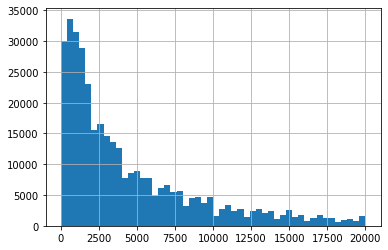

In [10]:
cars['Price'].hist(bins=50)

Т.к. около нулевых цен не много и они могут оказатся выбросами, чтобы не сбивать модель, избавимся от них и отбросим выбросы по правилу трёх сигм:

In [11]:
maximum = cars['Price'].mean() + (3 * np.std(cars['Price']))
minimum = 50  # cars['Price'].mean() + (3 * np.std(cars[Price]))
cars = cars.query('@minimum < Price < @maximum')

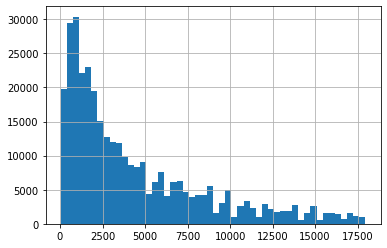

In [12]:
cars['Price'].hist(bins=50)

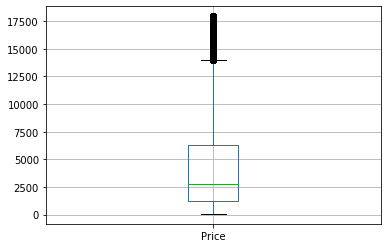

In [13]:
cars.boxplot(column=['Price'])

In [14]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,336135.000000,336135.000000,336135.000000,336135.000000,336135.000000,336135.0,336135.000000
mean,4344.905818,2003.899656,110.033002,129146.131763,5.786880,0.0,50626.758752
std,4150.196536,72.316816,189.263974,36731.166703,3.695358,0.0,25728.978164
min,55.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30419.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49479.000000
75%,6300.000000,2007.000000,140.000000,150000.000000,9.000000,0.0,71126.000000
max,17950.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [15]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336135 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          336135 non-null datetime64[ns]
Price                336135 non-null int64
VehicleType          303442 non-null object
RegistrationYear     336135 non-null int64
Gearbox              319671 non-null object
Power                336135 non-null int64
Model                319219 non-null object
Kilometer            336135 non-null int64
RegistrationMonth    336135 non-null int64
FuelType             307718 non-null object
Brand                336135 non-null object
NotRepaired          271801 non-null object
DateCreated          336135 non-null datetime64[ns]
NumberOfPictures     336135 non-null int64
PostalCode           336135 non-null int64
LastSeen             336135 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.6+ MB


In [16]:
cars['NumberOfPictures'].unique()

array([0])

In [17]:
cars['NumberOfPictures'].describe()

count    336135.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

В столбце NumberOfPictures имеем только значение 0. Есть смысл избавиться от него:

In [18]:
cars = cars.drop('NumberOfPictures', axis=1)

Рассмотрим признак Model:

In [19]:
cars['Model'].isna().sum()

16916

In [20]:
cars['Model'].unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'ka', 'polo', 'twingo', 'a_klasse', 'scirocco', '5er',
       'meriva', 'arosa', 'other', 'c4', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo', '1er',
       'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta', 'c_klasse',
       'micra', 'vito', 'sprinter', '156', nan, 'escort', 'forester',
       'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo', 'focus',
       'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'eos',
       'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', 'yeti', 'octavia',
       'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1',
     

Заполним пропуски словом 'other':

In [21]:
cars.query('Model == "other"')['Model'].count()

23078

In [22]:
cars['Model'].fillna('other', inplace=True)

In [23]:
cars.query('Model == "other"')['Model'].count()

39994

Заменим other на самые распространённые модели в каждом бренде:

In [24]:
for i in cars['Brand'].unique():
    list_oper = []
    for j in cars.query('Brand == @i')['Model'].unique():
        if j != 'other':
            list_oper.append(cars.query('Brand == @i and Model == @j')['Model'].count())
    try:
        max_count = max(list_oper)
    except:
        print(i)
    for j in cars.query('Brand == @i')['Model'].unique():
        if cars.query('Brand == @i and Model == @j')['Model'].count() == max_count:
            ind = cars.loc[(cars['Brand'] == i) & (cars['Model'] == 'other')].index
            cars.loc[ind, 'Model'] = j

sonstige_autos


In [25]:
cars.query('Model == "other"')['Brand'].unique()

array(['sonstige_autos'], dtype=object)

Остался один бренд с неизвестной моделью.

In [26]:
cars.query('Brand == "sonstige_autos"')['Model'].unique()

array(['other'], dtype=object)

Видимо у всего бренда не указано ни одной модели в данных.

In [27]:
cars.query('Brand == "sonstige_autos"').head(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,other,10000,0,NaN,sonstige_autos,NaN,2016-03-21,6493,2016-03-24 02:47:34
431,2016-03-20 20:45:27,3950,small,2004,auto,5,other,70000,5,gasoline,sonstige_autos,no,2016-03-20,90562,2016-04-03 04:17:08
650,2016-03-30 11:55:46,15000,coupe,1971,NaN,0,other,5000,4,NaN,sonstige_autos,no,2016-03-30,51145,2016-04-07 02:45:10
661,2016-04-01 15:56:27,9900,suv,2000,auto,250,other,150000,4,lpg,sonstige_autos,no,2016-04-01,17309,2016-04-07 14:56:03
700,2016-03-30 21:37:21,6999,sedan,2010,auto,186,other,125000,4,petrol,sonstige_autos,no,2016-03-30,81929,2016-04-05 11:18:33
985,2016-03-15 16:37:22,500,sedan,2010,manual,101,other,70000,1,petrol,sonstige_autos,yes,2016-03-15,76829,2016-03-21 14:15:21
999,2016-04-02 23:39:49,3900,wagon,1990,manual,0,other,30000,5,petrol,sonstige_autos,NaN,2016-04-02,15345,2016-04-07 01:46:23
1098,2016-03-06 22:43:51,11500,bus,1985,auto,160,other,125000,10,petrol,sonstige_autos,NaN,2016-03-06,4849,2016-04-05 18:17:04
1106,2016-03-22 11:38:37,9200,sedan,2005,auto,249,other,150000,10,petrol,sonstige_autos,no,2016-03-22,95447,2016-04-05 23:16:55
1274,2016-03-24 15:38:12,16990,small,2015,manual,135,other,20000,5,petrol,sonstige_autos,no,2016-03-24,74199,2016-04-07 07:16:51


С немецкого, это перевод - прочие автомобили. Есть смысл оставить модель unknown.  

Псмотрим на VehicleType:

In [28]:
cars['VehicleType'].unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

Заполним пропуски словом other:

In [29]:
cars['VehicleType'].fillna('other', inplace=True)

In [30]:
cars[cars['VehicleType'] == 'other'].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,other,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,other,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,other,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,other,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,37075,2016-03-29 17:43:07


Попробуем заменить other на самые частые кузова по брендам в моделях:

In [31]:
for i in cars['Brand'].unique():
    for j in cars.query('Brand == @i')['Model'].unique():
        list_oper = []
        for k in cars.query('Brand == @i and Model == @j')['VehicleType'].unique():
            if k != 'other':
                list_oper.append(cars.query('Brand == @i and Model == @j and VehicleType == @k')['VehicleType'].count())
        max_count = max(list_oper)
        for k in cars.query('Brand == @i and Model == @j')['VehicleType'].unique():
            if cars.query('Brand == @i and Model == @j and VehicleType == @k')['VehicleType'].count() == max_count:
                ind = cars.loc[(cars['Brand'] == i) & (cars['Model'] == j) & (cars['VehicleType'] == 'other')].index
                cars.loc[ind, 'VehicleType'] = k

In [32]:
cars['VehicleType'].unique()

array(['sedan', 'suv', 'small', 'convertible', 'bus', 'wagon', 'coupe'],
      dtype=object)

Рассмотрим RegistrationYear:

In [33]:
cars['RegistrationYear'].describe()

count    336135.000000
mean       2003.899656
std          72.316816
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [34]:
print('Автомобилой с датой регистрации до 1970 года - {:.2%}'.format(cars[cars['RegistrationYear'] < 1970]['RegistrationYear'].count() / cars['RegistrationYear'].shape[0]))

Автомобилой с датой регистрации до 1970 года - 0.31%


Удалим подозрительные гогда регистрации машин.

In [35]:
cars = cars.loc[(cars['RegistrationYear'] < 2019) | (cars['RegistrationYear'] > 1970)]

In [36]:
cars['RegistrationYear'].unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016, 2007,
       2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991, 1984,
       2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2011,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 3200, 1000, 1941,
       9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000, 2066,
       1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 8000, 5300,
       9000, 2900, 6000, 5900, 5911, 1400, 5000, 1950, 4000, 1948, 1952,
       1956, 8500, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936,
       1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928,
       5555, 5600, 1600, 1111, 1932, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

Рассмотрим признак Gearbox:

In [37]:
cars['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Заменим пропуски на unknown_, т.к. выяcнить вид коробки невозможно, у многих моделей присутсвует и механика и автомат:

In [38]:
cars['Gearbox'].fillna('unknown_', inplace=True)
cars.query('Gearbox == "unknown_"').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,unknown_,0,ka,5000,0,petrol,ford,NaN,2016-03-11,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,small,2016,unknown_,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,unknown_,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,bus,2016,unknown_,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,unknown_,0,astra,150000,0,NaN,opel,NaN,2016-04-01,47249,2016-04-07 08:46:07


Рассмотрим признак Power:

In [39]:
cars['Power'].describe()

count    336135.000000
mean        110.033002
std         189.263974
min           0.000000
25%          69.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

In [40]:
print('Машины свыше 300 лошадиных сил в данных около {:.2%}.'.format(cars.query('Power > 300')['Power'].count() / cars['Power'].shape[0]))
print('Машины с 0 лошадиных сил в данных около {:.2%}.'.format(cars.query('Power == 0')['Power'].count() / cars['Power'].shape[0]))
print('Машины ниже 50 лошадиных сил в данных около {:.2%}.'.format(cars.query('Power < 40')['Power'].count() / cars['Power'].shape[0]))

Машины свыше 300 лошадиных сил в данных около 0.88%.
Машины с 0 лошадиных сил в данных около 10.47%.
Машины ниже 50 лошадиных сил в данных около 10.87%.


Часть данных явно выбивается. Машины мене 40 лошадиных сил и более 300 сил мене процента в данных. Заменим их медианным значением по моделям:

In [41]:
for i in cars['Model'].unique():
    new_power = cars.query('Model == @i')['Power'].median()  # mean()
    if 300 < new_power or new_power < 40:
        new_power = cars['Power'].median()  # mean()
    ind = cars.query('(Power < 40 or Power > 300) and Model == @i').index
    cars.loc[ind, 'Power'] = new_power

In [42]:
cars['Power'] = cars['Power'].astype('int64')
cars['Power'].describe()

count    336135.000000
mean        116.020682
std          47.442216
min          40.000000
25%          75.000000
50%         109.000000
75%         143.000000
max         300.000000
Name: Power, dtype: float64

Рассмотрим признак Kilometer:

In [43]:
cars['Kilometer'].unique()

array([150000, 125000,  90000,  30000,   5000, 100000,  60000,  70000,
        80000,  50000,  40000,  20000,  10000])

In [44]:
cars['Kilometer'].describe()

count    336135.000000
mean     129146.131763
std       36731.166703
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Километры не вызывают подозрений.  

Рассмотрим признак RegistrationMonth:

In [45]:
sorted(cars['RegistrationMonth'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [46]:
cars['RegistrationMonth'].describe()

count    336135.000000
mean          5.786880
std           3.695358
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

Нулевой месяц - это странно.

In [47]:
print('Таких данных около {:.0%}. Удалим их'.format(cars[cars['RegistrationMonth'] == 0]['RegistrationMonth'].count() / cars.shape[0]))

Таких данных около 9%. Удалим их


In [48]:
cars = cars[cars['RegistrationMonth'] != 0]

Рассмотрим признак FuelType:

In [49]:
cars['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Заполним пропуски other:

In [50]:
cars['FuelType'] = cars['FuelType'].fillna('other')

Заменим other на тип топлива по моделям:

In [51]:
for i in cars['Model'].unique():
    list_oper= []
    for j in cars[cars['Model'] == i]['FuelType'].unique():
        if j != 'other':
            list_oper.append(cars[(cars['Model'] == i) & (cars['FuelType'] == j)]['FuelType'].count())   
    try:
        max_num = max(list_oper)
    except:
        print(i)
    for j in cars[cars['Model'] == i]['FuelType'].unique():
        if max_num == cars[(cars['Model'] == i) & (cars['FuelType'] == j)]['FuelType'].count():
            ind = cars.loc[(cars['Model'] == i) & (cars['FuelType'] == 'other')].index
            cars.loc[ind, 'FuelType'] = j

In [52]:
cars[cars['Model'] == 'golf']['FuelType'].unique()

array(['petrol', 'gasoline', 'lpg', 'cng', 'hybrid', 'electric'],
      dtype=object)

Рассмотрим признак Brand:

In [53]:
cars['Brand'].isna().sum()

0

In [54]:
cars['Brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'renault', 'mercedes_benz', 'opel', 'seat', 'citroen', 'honda',
       'fiat', 'mini', 'smart', 'hyundai', 'audi', 'nissan', 'subaru',
       'volvo', 'mitsubishi', 'alfa_romeo', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'sonstige_autos', 'daihatsu',
       'chrysler', 'jaguar', 'rover', 'porsche', 'daewoo', 'saab',
       'trabant', 'land_rover', 'lada'], dtype=object)

Ничего подозрительного не выявлено.  

Рассмотрим NotRepaired:

In [55]:
cars['NotRepaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

Заполним пропуски unknown, т.к. невозможно вытащить данные о ремонте.

In [56]:
cars['NotRepaired'] = cars['NotRepaired'].fillna('unknown')
cars[cars['NotRepaired'] != 'unknown']['NotRepaired'].count()

258274

Посмотримн на признак DateCreated:

In [57]:
cars['DateCreated'].unique()

array(['2016-03-14T00:00:00.000000000', '2016-03-17T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-04-04T00:00:00.000000000',
       '2016-04-01T00:00:00.000000000', '2016-03-26T00:00:00.000000000',
       '2016-04-07T00:00:00.000000000', '2016-03-15T00:00:00.000000000',
       '2016-03-21T00:00:00.000000000', '2016-03-20T00:00:00.000000000',
       '2016-03-23T00:00:00.000000000', '2016-03-27T00:00:00.000000000',
       '2016-03-12T00:00:00.000000000', '2016-03-13T00:00:00.000000000',
       '2016-03-18T00:00:00.000000000', '2016-03-10T00:00:00.000000000',
       '2016-03-07T00:00:00.000000000', '2016-03-09T00:00:00.000000000',
       '2016-03-08T00:00:00.000000000', '2016-04-03T00:00:00.000000000',
       '2016-03-29T00:00:00.000000000', '2016-03-28T00:00:00.000000000',
       '2016-03-25T00:00:00.000000000', '2016-03-30T00:00:00.000000000',
       '2016-03-22T00:00:00.000000000', '2016-02-09T00:00:00.000000000',
       '2016-03-05T00:00:00.000000000', '2016-03-11

Ничего необычного.  

Посмотрим на LastSeen:

In [58]:
cars['LastSeen'].unique()

array(['2016-04-05T12:47:46.000000000', '2016-03-17T17:40:17.000000000',
       '2016-04-06T10:17:21.000000000', ...,
       '2016-03-19T20:44:43.000000000', '2016-03-29T10:17:23.000000000',
       '2016-03-24T12:45:21.000000000'], dtype='datetime64[ns]')

In [59]:
cars['LastSeen'].describe()

count                  304319
unique                 159773
top       2016-04-06 12:15:45
freq                       16
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

Ничего странного.  

Для модели, признаки почтовый индекс пользователя, последняя активность, дата создания, дата скачивания объявления вероятно не нужны, т.к. скорее всего, это информация ресурса, откуда был скачан датасет и не влиют на цену автомобиля. Удалим их:

In [3]:
cars = cars.drop(['LastSeen', 'PostalCode', 'DateCreated', 'DateCrawled'], axis=1)

In [61]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304319 entries, 2 to 354368
Data columns (total 11 columns):
Price                304319 non-null int64
VehicleType          304319 non-null object
RegistrationYear     304319 non-null int64
Gearbox              304319 non-null object
Power                304319 non-null int64
Model                304319 non-null object
Kilometer            304319 non-null int64
RegistrationMonth    304319 non-null int64
FuelType             304319 non-null object
Brand                304319 non-null object
NotRepaired          304319 non-null object
dtypes: int64(5), object(6)
memory usage: 37.9+ MB


Посмотрим, есть ли дубликаты:

In [62]:
cars.duplicated().sum()

25508

Избавимся от дубликатов:

In [63]:
cars = cars.drop_duplicates().reset_index(drop=True)

In [64]:
cars.duplicated().sum()

0

Данные предобработаны. Можно переходить к моделям.

# 2. Обучение моделей.<a id='2_Обучение_моделей.'></a>

Проверим корреляцию признаков:

In [4]:
features = cars.drop('Price', axis=1)
target = cars['Price']

In [66]:
features.head(2)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
1,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no


In [67]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278811 entries, 0 to 278810
Data columns (total 10 columns):
VehicleType          278811 non-null object
RegistrationYear     278811 non-null int64
Gearbox              278811 non-null object
Power                278811 non-null int64
Model                278811 non-null object
Kilometer            278811 non-null int64
RegistrationMonth    278811 non-null int64
FuelType             278811 non-null object
Brand                278811 non-null object
NotRepaired          278811 non-null object
dtypes: int64(4), object(6)
memory usage: 21.3+ MB


In [68]:
for i in ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'Price']:
    for j in ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'Price']:
        if i != j:
            correl = cars[i].corr(cars[j])
            if correl > 0.3 or correl < -0.3:
                print(f'Корреляция {i} и {j} больше или меньше 0.9 = {correl}')

Корреляция Power и Price больше или меньше 0.9 = 0.4850234766337619
Корреляция Kilometer и Price больше или меньше 0.9 = -0.3561106201123081
Корреляция Price и Power больше или меньше 0.9 = 0.4850234766337619
Корреляция Price и Kilometer больше или меньше 0.9 = -0.3561106201123081


Power и Price - имеют слабую корреляцию - почти 0.5. Остальные признаки не кореллируют.

Закодируем категориальные признаки OHE:

In [69]:
list_columns_cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [70]:
ohe = OneHotEncoder()
features_ohe = ohe.fit_transform(features[list_columns_cat]).toarray()
features_ohe = pd.DataFrame(features_ohe, columns=[j for i in ohe.categories_ for j in i])
features_ohe.head()

,bus,convertible,coupe,sedan,small,suv,wagon,auto,manual,unknown_,...,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo,no,unknown,yes
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Объединим закодированную таблицу с основной для Линейной регрессии:

In [71]:
features_ohe = features.join(features_ohe)
features_ohe = features_ohe.drop(list_columns_cat, axis=1)

Отмасштабируем признаки:

In [72]:
#list_oper = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
#scaler = StandardScaler()
#scaler.fit(features_ohe[list_oper])

#features_ohe[list_oper] = scaler.transform(features_ohe[list_oper])

In [73]:
features_ohe.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,bus,convertible,coupe,sedan,small,suv,...,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo,no,unknown,yes
0,2004,163,125000,8,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2001,75,150000,6,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2008,69,90000,7,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1995,102,150000,10,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2004,109,150000,8,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [74]:
oe = OrdinalEncoder()

In [75]:
features_oe = pd.DataFrame(oe.fit_transform(features[list_columns_cat]), columns=list_columns_cat)
features_oe = features.drop(list_columns_cat, axis=1).join(features_oe)
features_oe.head(3)

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,2004,163,125000,8,5.0,0.0,117.0,2.0,14.0,1.0
1,2001,75,150000,6,4.0,1.0,116.0,5.0,38.0,0.0
2,2008,69,90000,7,4.0,1.0,101.0,2.0,31.0,0.0


Разобъём выборку на трэйн и тест:

In [76]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [77]:
features_train_valid_ohe, features_test_ohe, target_train_valid_ohe, target_test_ohe = train_test_split(features_ohe, target, test_size=0.2, random_state=12345)
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_train_valid_ohe, target_train_valid_ohe, test_size=0.2, random_state=12345)

In [78]:
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(features_oe, target, test_size=0.2, random_state=12345)

Отмасштабируем признаки:

In [79]:
list_oper = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
scaler = StandardScaler()
scaler.fit(features_train_valid_ohe[list_oper])

#features_train_valid_ohe = features_train_valid_ohe.copy()
features_train_ohe = features_train_ohe.copy()
features_valid_ohe = features_valid_ohe.copy()
features_test_ohe = features_test_ohe.copy()

#features_train_valid_ohe[:, list_oper] = scaler.transform(features_train_valid_ohe[list_oper])
features_train_ohe.loc[:, list_oper] = scaler.transform(features_train_ohe[list_oper])
features_valid_ohe.loc[:, list_oper] = scaler.transform(features_valid_ohe[list_oper])
features_test_ohe.loc[:, list_oper] = scaler.transform(features_test_ohe[list_oper])

Подготовим score для GridSearchCV:

In [80]:
mean_squared_error_gs = make_scorer(mean_squared_error, greater_is_better=False)

Сначала пообучаем и посмотрим на результаты Линейной регрессии:  
Подберём лучшие параметры с грид сёрч:

In [81]:
param_grid_linr = {'fit_intercept':[True,False], 'normalize':[True,False]}
gs_linr = GridSearchCV(LinearRegression(), param_grid=param_grid_linr, scoring=mean_squared_error_gs, cv=5)
gs_linr = GridSearchCV(LinearRegression(), param_grid=param_grid_linr, scoring='neg_mean_squared_error', cv=5)
gs_linr.fit(features_train_valid_ohe, target_train_valid_ohe)

In [82]:
best_lr = gs_linr.best_params_
score_lr = (np.abs(gs_linr.best_score_)) ** 0.5
print(f'Лучшие параметры = {best_lr}')
print('Качество модели на кросс валидации = {:.5}'.format(score_lr))

Лучшие параметры = {'fit_intercept': False, 'normalize': True}  
Качество модели на кросс валидации = 1.6942e+10

In [83]:
gs_linr.cv_results_ 

{'mean_fit_time': array([27.51791973, 29.27943835, 29.08306026, 28.24139051]),  
  'std_fit_time': array([1.48844907, 1.37919852, 0.95364016, 0.83394658]),  
  'mean_score_time': array([0.08591247, 0.09931817, 0.09950018, 0.12295127]),  
  'std_score_time': array([0.03701156, 0.05221231, 0.0126849 , 0.03003295]),  
  'param_fit_intercept': masked_array(data=[True, True, False, False],  
                         mask=[False, False, False, False],  
                         fill_value='?',  
                         dtype=object),  
  'param_normalize': masked_array(data=[True, False, True, False],  
                     mask=[False, False, False, False],  
                     fill_value='?',  
                     dtype=object),  
  'params': [{'fit_intercept': True, 'normalize': True},  
             {'fit_intercept': True, 'normalize': False},  
             {'fit_intercept': False, 'normalize': True},  
             {'fit_intercept': False, 'normalize': False}],  
  'split0_test_score': array([-7186307.27939924, -7174497.8420564 , -7174500.26365051,  
                              -7174500.26365051]),  
  'split1_test_score': array([-8.05352726e+32, -1.37821691e+22, -1.43514327e+21, -1.43514327e+21]),  
  'split2_test_score': array([-7476436.22237167, -7468044.76828168, -7468026.2267653 ,  
                              -7468026.2267653 ]),  
  'split3_test_score': array([-7326656.20195476, -7314296.51412867, -7314250.54899122,  
                              -7314250.54899122]),  
  'split4_test_score': array([-7196858.68719317, -7190734.77325203, -7190836.83825909,  
                              -7190836.83825909]),  
  'mean_test_score': array([-1.61071989e+32, -2.75645854e+21, -2.87031227e+20, -2.87031227e+20]),  
  'std_test_score': array([3.22142174e+32, 5.51288618e+21, 5.74059237e+20, 5.74059237e+20]),  
  'rank_test_score': array([4, 3, 1, 1], dtype=int32)}  

Попробуем пообучать регрессию бустингом

In [85]:
%%time
model_lr = LinearRegression(fit_intercept=False, normalize=True)
pred = np.zeros(len(target_train_ohe)) ### почему валидационная?
iters = 1
lerning_rate = 1
list_model_lr = [i for i in range(iters)]
list_model_lr.append(model_lr.fit(features_train_ohe, target_train_ohe))  
for i in range(iters):
    pred += (model_lr.predict(features_train_ohe) * lerning_rate) ### почему валидационная?
    error = target_train_ohe - pred ### почему валидационная?
    model_lr = model_lr.fit(features_train_ohe, error) ### почему валидационная?
    list_model_lr[i] = model_lr

CPU times: user 36.3 s, sys: 12.8 s, total: 49.2 s  
Wall time: 49.3 s  

In [86]:
%%time
pred = np.zeros(len(target_valid_ohe))
for i in list_model_lr:
    pred += i.predict(features_valid_ohe)
print(f'RMSE валидации после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_valid_ohe, pred) ** 0.5)}')

RMSE валидации после 1 итераций с шагом 1 = 6240.0  
CPU times: user 227 ms, sys: 175 ms, total: 401 ms  
Wall time: 393 ms

In [87]:
%%time
pred = np.zeros(len(target_test_ohe))
for i in list_model_lr:
    pred += i.predict(features_test_ohe)
print(f'RMSE теста после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_test_ohe, pred) ** 0.5)}')

RMSE теста после 1 итераций с шагом 1 = 6215.0  
CPU times: user 280 ms, sys: 168 ms, total: 447 ms  
Wall time: 413 ms

In [88]:
%%time
model_lr = LinearRegression(fit_intercept=False, normalize=True)
pred = np.zeros(len(target_train_ohe))
iters = 2
lerning_rate = 1
list_model_lr = [i for i in range(iters)]
list_model_lr.append(model_lr.fit(features_train_ohe, target_train_ohe))  
for i in range(iters):
    pred += (model_lr.predict(features_train_ohe) * lerning_rate)
    error = target_train_ohe - pred
    model_lr = model_lr.fit(features_train_ohe, error)
    list_model_lr[i] = model_lr

CPU times: user 51.3 s, sys: 20 s, total: 1min 11s  
Wall time: 1min 11s

In [89]:
%%time
pred = np.zeros(len(target_valid_ohe))
for i in list_model_lr:
    pred += i.predict(features_valid_ohe)
print(f'RMSE валидации после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_valid_ohe, pred) ** 0.5)}')

RMSE валидации после 2 итераций с шагом 1 = 6240.0  
CPU times: user 283 ms, sys: 169 ms, total: 452 ms  
Wall time: 404 ms

In [90]:
%%time
pred = np.zeros(len(target_test_ohe))
for i in list_model_lr:
    pred += i.predict(features_test_ohe)
print(f'RMSE теста после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_test_ohe, pred) ** 0.5)}')

RMSE теста после 2 итераций с шагом 1 = 6216.0  
CPU times: user 284 ms, sys: 198 ms, total: 482 ms  
Wall time: 417 ms  

In [91]:
%%time
model_lr = LinearRegression(fit_intercept=False, normalize=True)
pred = np.zeros(len(target_train_ohe))
iters = 2
lerning_rate = 1.5
list_model_lr = [i for i in range(iters)]
list_model_lr.append(model_lr.fit(features_train_ohe, target_train_ohe))  
for i in range(iters):
    pred += (model_lr.predict(features_train_ohe) * lerning_rate)
    error = target_train_ohe - pred
    model_lr = model_lr.fit(features_train_ohe, error)
    list_model_lr[i] = model_lr

CPU times: user 51.3 s, sys: 19.6 s, total: 1min 10s  
Wall time: 1min 11s

In [92]:
%%time
pred = np.zeros(len(target_valid_ohe))
for i in list_model_lr:
    pred += i.predict(features_valid_ohe)
print(f'RMSE валидации после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_valid_ohe, pred) ** 0.5)}')

RMSE валидации после 2 итераций с шагом 1.5 = 3059.0  
CPU times: user 245 ms, sys: 218 ms, total: 463 ms  
Wall time: 412 ms

In [93]:
%%time
pred = np.zeros(len(target_test_ohe))
for i in list_model_lr:
    pred += i.predict(features_test_ohe)
print(f'RMSE теста после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_test_ohe, pred) ** 0.5)}')

RMSE теста после 2 итераций с шагом 1.5 = 3032.0  
CPU times: user 326 ms, sys: 178 ms, total: 504 ms  
Wall time: 592 ms

In [94]:
%%time
model_lr = LinearRegression(fit_intercept=False, normalize=True)
pred = np.zeros(len(target_train_ohe))
iters = 3
lerning_rate = 1
list_model_lr = [i for i in range(iters)]
list_model_lr.append(model_lr.fit(features_train_ohe, target_train_ohe))  
for i in range(iters):
    pred += (model_lr.predict(features_train_ohe) * lerning_rate)
    error = target_train_ohe - pred
    model_lr = model_lr.fit(features_train_ohe, error)
    list_model_lr[i] = model_lr

CPU times: user 1min 10s, sys: 28.5 s, total: 1min 38s  
Wall time: 1min 38s

In [95]:
%%time
pred = np.zeros(len(target_valid_ohe))
for i in list_model_lr:
    pred += i.predict(features_valid_ohe)
print(f'RMSE валидации после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_valid_ohe, pred) ** 0.5)}')

RMSE валидации после 3 итераций с шагом 1 = 6239.0  
CPU times: user 295 ms, sys: 245 ms, total: 539 ms  
Wall time: 500 ms

In [96]:
%%time
pred = np.zeros(len(target_test_ohe))
for i in list_model_lr:
    pred += i.predict(features_test_ohe)
print(f'RMSE теста после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_test_ohe, pred) ** 0.5)}')

RMSE теста после 3 итераций с шагом 1 = 6214.0  
CPU times: user 403 ms, sys: 356 ms, total: 759 ms  
Wall time: 795 ms

In [97]:
%%time
model_lr = LinearRegression(fit_intercept=False, normalize=True)
pred = np.zeros(len(target_train_ohe))
iters = 20
lerning_rate = 1
list_model_lr = [i for i in range(iters)]
list_model_lr.append(model_lr.fit(features_train_ohe, target_train_ohe))  
for i in range(iters):
    pred += (model_lr.predict(features_train_ohe) * lerning_rate)
    error = target_train_ohe - pred
    model_lr = model_lr.fit(features_train_ohe, error)
    list_model_lr[i] = model_lr

CPU times: user 5min 33s, sys: 2min 16s, total: 7min 49s  
Wall time: 7min 50s

In [98]:
%%time
pred = np.zeros(len(target_valid_ohe))
for i in list_model_lr:
    pred += i.predict(features_valid_ohe)
print(f'RMSE валидации после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_valid_ohe, pred) ** 0.5)}')

RMSE валидации после 20 итераций с шагом 1 = 6238.0  
CPU times: user 1.47 s, sys: 1.13 s, total: 2.6 s  
Wall time: 2.6 s

In [99]:
%%time
pred = np.zeros(len(target_test_ohe))
for i in list_model_lr:
    pred += i.predict(features_test_ohe)
print(f'RMSE теста после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_test_ohe, pred) ** 0.5)}')

RMSE теста после 20 итераций с шагом 1 = 6214.0  
CPU times: user 1.78 s, sys: 1.04 s, total: 2.82 s  
Wall time: 2.8 s

In [100]:
%%time
model_lr = LinearRegression(fit_intercept=False, normalize=True)
pred = np.zeros(len(target_train_ohe))
iters = 20
lerning_rate = 1.5
list_model_lr = [i for i in range(iters)]
list_model_lr.append(model_lr.fit(features_train_ohe, target_train_ohe))  
for i in range(iters):
    pred += (model_lr.predict(features_train_ohe) * lerning_rate)
    error = target_train_ohe - pred
    model_lr = model_lr.fit(features_train_ohe, error)
    list_model_lr[i] = model_lr

CPU times: user 5min 22s, sys: 1min 34s, total: 6min 57s  
Wall time: 6min 59s

In [101]:
%%time
pred = np.zeros(len(target_valid_ohe))
for i in list_model_lr:
    pred += i.predict(features_valid_ohe)
print(f'RMSE валидации после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_valid_ohe, pred) ** 0.5)}')

RMSE валидации после 20 итераций с шагом 1.5 = 6232.0  
CPU times: user 1.77 s, sys: 1.28 s, total: 3.04 s  
Wall time: 3 s

In [102]:
%%time
pred = np.zeros(len(target_test_ohe))
for i in list_model_lr:
    pred += i.predict(features_test_ohe)
print(f'RMSE теста после {iters} итераций с шагом {lerning_rate} = {np.round(mean_squared_error(target_test_ohe, pred) ** 0.5)}')

RMSE теста после 20 итераций с шагом 1.5 = 6208.0  
CPU times: user 2.16 s, sys: 1.43 s, total: 3.59 s  
Wall time: 3.6 s

Посмотрим на CatBoostRegressor:  
Сначала CV:

In [103]:
cv_dataset = Pool(data=features_train,
                  label=target_train,
                  cat_features=list_columns_cat)


for j in range(2, 12, 3):
    params = {"iterations": 100,
              "depth": j,
              "loss_function": "RMSE",
              "verbose": False}
    scores = cv(cv_dataset,
                params,
                fold_count=5)
    mean_scores = scores['test-RMSE-mean'].mean() ### лучше усреднить
    print(f'Глубина {j}, результат = {mean_scores}')

Глубина 2, результат = 3405.522886492886  
Глубина 5, результат = 3065.131387128507  
Глубина 8, результат = 2942.2837834882257  
Глубина 11, результат = 2887.5366718724745

In [104]:
%%time
iters = 100
depth = 2
model_catboost = CatBoostRegressor(iterations=iters, depth=depth, loss_function='RMSE')
model_catboost.fit(features_train, target_train, cat_features=list_columns_cat, verbose=50)

0:	learn: 4154.6366987	total: 151ms	remaining: 14.9s  
50:	learn: 2850.2159344	total: 8.42s	remaining: 8.09s  
99:	learn: 2447.9516093	total: 16.6s	remaining: 0us  
CPU times: user 15.5 s, sys: 2.17 s, total: 17.7 s  
Wall time: 18.7 s  

In [105]:
%%time
pred = model_catboost.predict(features_test)
print(f'RMSE с глубиной {depth} = {np.round(mean_squared_error(target_test_ohe, pred) ** 0.5)}')

RMSE с глубиной 2 = 2432.0  
CPU times: user 147 ms, sys: 31.2 ms, total: 178 ms  
Wall time: 154 ms  

In [106]:
%%time
depth = 8
model_catboost = CatBoostRegressor(iterations=iters, depth=depth, loss_function='RMSE')
model_catboost.fit(features_train, target_train, cat_features=list_columns_cat, verbose=50)

0:	learn: 4127.3553542	total: 510ms	remaining: 50.5s  
50:	learn: 2223.4900209	total: 23.8s	remaining: 22.8s  
99:	learn: 1867.8937414	total: 46.1s	remaining: 0us  
CPU times: user 41 s, sys: 6.22 s, total: 47.3 s  
Wall time: 48.2 s  

In [107]:
%%time
pred = model_catboost.predict(features_test)
print(f'RMSE с глубиной {depth} = {np.round(mean_squared_error(target_test_ohe, pred) ** 0.5)}')

RMSE с глубиной 8 = 1855.0  
CPU times: user 162 ms, sys: 12.3 ms, total: 174 ms  
Wall time: 152 ms  

In [108]:
%%time
depth = 11
model_catboost = CatBoostRegressor(iterations=iters, depth=depth, loss_function='RMSE')
model_catboost.fit(features_train, target_train, cat_features=list_columns_cat, verbose=50)

0:	learn: 4123.4632372	total: 650ms	remaining: 1m 4s  
50:	learn: 2124.4949530	total: 31.5s	remaining: 30.3s  
99:	learn: 1774.2106008	total: 1m 1s	remaining: 0us  
CPU times: user 53.9 s, sys: 8.01 s, total: 1min 1s  
Wall time: 1min 3s  

In [109]:
%%time
pred = model_catboost.predict(features_test)
print(f'RMSE с глубиной {depth} = {np.round(mean_squared_error(target_test_ohe, pred) ** 0.5)}')

RMSE с глубиной 11 = 1770.0  
CPU times: user 231 ms, sys: 2.81 ms, total: 234 ms  
Wall time: 234 ms  

In [110]:
del cars
del scaler
del features
del target
del features_test
del target_test
del features_train
del target_train
del features_train_ohe
del target_train_ohe
del features_train_valid_ohe
del target_train_valid_ohe
del features_test_ohe
del target_test_ohe
#del model_lr
#del list_model_lr
#del pred
#del model_catboost
#del depth
#del error
del list_oper

Теперь посмотрим на LightGBM:  
Сначала cv:

In [111]:
param_grid_lgbmr = {'learning_rate':[0.1, 0.3, 0.5], 'n_estimators':[50, 100, 150]}
gs_lgbmr = GridSearchCV(LGBMRegressor(), param_grid=param_grid_lgbmr, scoring=mean_squared_error_gs, cv=5)
gs_lgbmr.fit(features_train_oe, target_train_oe)
# gs_lgbmr.fit(features_train_oe, target_train_oe, categorical_feature=list_columns_cat)
# gs_lgbmr.fit(features_train_oe, target_train_oe, feature_name=list(features_train_oe.columns), categorical_feature=list_columns_cat)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'n_estimators': [50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, ret

In [112]:
best_lgbmr = gs_lgbmr.best_params_
score_lgbmr = (np.abs(gs_lgbmr.best_score_)) ** 0.5
print(f'Лучшие параметры = {best_lgbmr}')
print('Качество модели на кросс валидации = {:.5}'.format(score_lgbmr))

Лучшие параметры = {'learning_rate': 0.3, 'n_estimators': 150}
Качество модели на кросс валидации = 1602.5


In [113]:
gs_lgbmr.cv_results_ 

{'mean_fit_time': array([61.87025084, 59.04071646, 25.15610175,  3.47432232, 22.8969655 ,
         8.11434364,  3.39432125,  5.69775362,  7.89526591]),
 'std_fit_time': array([10.60539301, 42.50420817, 30.07438058,  0.0952581 , 23.24977389,
         0.5055622 ,  0.16486333,  0.29402937,  0.38234993]),
 'mean_score_time': array([0.30349317, 0.55803084, 0.76449437, 0.24332585, 0.38365779,
        0.58568034, 0.22060795, 0.34228172, 0.50487962]),
 'std_score_time': array([0.00375676, 0.039404  , 0.0435518 , 0.04220567, 0.03683986,
        0.0355955 , 0.03638948, 0.04274379, 0.00380749]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.3, 0.3, 0.3, 0.5, 0.5, 0.5],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 150, 50, 100, 150, 50, 100, 150],
              mask=[False, False, False, False, False, False, False, False,
  

Теперь посмотрим на различные варианты параметров:

In [115]:
learning_rate = 0.5
n_estimators = 50

In [116]:
%%time
model_lgbmr = LGBMRegressor(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    metric='rmse',
    random_state=12345
)
model_lgbmr.fit(features_train_oe, target_train_oe, eval_metric='rmse')
# model_lgbmr.fit(features_train_oe, target_train_oe, eval_metric='rmse',feature_name=list(features_train_oe.columns), categorical_feature=list_columns_cat)

CPU times: user 3.75 s, sys: 8 ms, total: 3.76 s
Wall time: 3.77 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [117]:
%%time
pred = model_lgbmr.predict(features_test_oe)
print(f'RMSE с шагом {learning_rate} и количеством деревьев {n_estimators} = {np.round(mean_squared_error(target_test_oe, pred) ** 0.5)}')

RMSE с шагом 0.5 и количеством деревьев 50 = 1637.0
CPU times: user 257 ms, sys: 0 ns, total: 257 ms
Wall time: 290 ms


In [118]:
learning_rate = 0.3
n_estimators = 100

In [119]:
%%time
model_lgbmr = LGBMRegressor(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    metric='rmse',
    random_state=12345
)
model_lgbmr.fit(features_train_oe, target_train_oe, eval_metric='rmse')  #,feature_name=list(features_train_oe.columns), categorical_feature=list_columns_cat)

CPU times: user 7.2 s, sys: 20.3 ms, total: 7.22 s
Wall time: 7.38 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [120]:
%%time
pred = model_lgbmr.predict(features_test_oe)
print(f'RMSE с шагом {learning_rate} и количеством деревьев {n_estimators} = {np.round(mean_squared_error(target_test_oe, pred) ** 0.5)}')

RMSE с шагом 0.3 и количеством деревьев 100 = 1598.0
CPU times: user 445 ms, sys: 3.9 ms, total: 449 ms
Wall time: 402 ms


In [121]:
learning_rate = 0.1
n_estimators = 150

In [122]:
%%time
model_lgbmr = LGBMRegressor(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    metric='rmse',
    random_state=12345
)
model_lgbmr.fit(features_train_oe, target_train_oe, eval_metric='rmse')  #,feature_name=list(features_train_oe.columns), categorical_feature=list_columns_cat)

CPU times: user 25.6 s, sys: 127 ms, total: 25.8 s
Wall time: 26.4 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [123]:
%%time
pred = model_lgbmr.predict(features_test_oe)
print(f'RMSE с шагом {learning_rate} и количеством деревьев {n_estimators} = {np.round(mean_squared_error(target_test_oe, pred) ** 0.5)}')

RMSE с шагом 0.1 и количеством деревьев 150 = 1623.0
CPU times: user 985 ms, sys: 7.55 ms, total: 992 ms
Wall time: 996 ms


In [124]:
learning_rate = 0.1
n_estimators = 200

In [125]:
%%time
model_lgbmr = LGBMRegressor(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    metric='rmse',
    random_state=12345
)
model_lgbmr.fit(features_train_oe, target_train_oe, eval_metric='rmse')  #,feature_name=list(features_train_oe.columns), categorical_feature=list_columns_cat)

CPU times: user 36.2 s, sys: 138 ms, total: 36.3 s
Wall time: 36.7 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [126]:
%%time
pred = model_lgbmr.predict(features_test_oe)
print(f'RMSE с шагом {learning_rate} и количеством деревьев {n_estimators} = {np.round(mean_squared_error(target_test_oe, pred) ** 0.5)}')

RMSE с шагом 0.1 и количеством деревьев 200 = 1602.0
CPU times: user 1.34 s, sys: 7.66 ms, total: 1.35 s
Wall time: 1.32 s


In [127]:
learning_rate = 0.3
n_estimators = 150

In [128]:
%%time
model_lgbmr = LGBMRegressor(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    metric='rmse',
    random_state=12345
)
model_lgbmr.fit(features_train_oe, target_train_oe, eval_metric='rmse')  #,feature_name=list(features_train_oe.columns), categorical_feature=list_columns_cat)

CPU times: user 31.7 s, sys: 80.8 ms, total: 31.7 s
Wall time: 32.3 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [129]:
%%time
pred = model_lgbmr.predict(features_test_oe)
print(f'RMSE с шагом {learning_rate} и количеством деревьев {n_estimators} = {np.round(mean_squared_error(target_test_oe, pred) ** 0.5)}')

RMSE с шагом 0.3 и количеством деревьев 150 = 1578.0
CPU times: user 789 ms, sys: 0 ns, total: 789 ms
Wall time: 795 ms


# 3. Анализ моделей.<a id="3_Анализ_моделей."></a>

- Линейная регрессия:  
На валидационной выборке наилучшее качество получилось с параметрами iters = 2 и lerning_rate = 1.5 rmse = 3059.0. Качество на тестовой выборке с этими параметраметрами, соответсвенно тоже наилучшее = 3032.0.  

Тестовые результаты:  
Время обучения с 2 итерациями с шагом 1 = 1min 3s. Время предсказания = 418 ms. Метрика RMSE = 6216.0.  
Время обучения с 3 итерациями с шагом 1 = 1min 40s. Время предсказания = 782 ms. Метрика RMSE = 6214.0.  
Время обучения с 20 итерациями с шагом 1 = 7min 50s. Время предсказания =  2.8 s. Метрика RMSE = 6214.0.  
Качество на простой линейной регрессии при этом всеравно выше.  


- КэтБуст:
Наилучшее качество на кросс валидации получилось с глубиной 11 = 2889. Проверка на тестовой выборке подтвердила, что с такой глубиной среди выбранных, получается наилучшее качество.  

Время обучения с глубиной дерева 2 = 18.7 s. Время предсказания = 154 ms. Метрика RMSE = 2432.0  
Время обучения с глубиной дерева 8 = 48.2 s. Время предсказания = 152 ms. Метрика RMSE = 1855.0  
Время обучения с глубиной дерева 11 = 1 min 3 s. Время предсказания = 234 ms. Метрика RMSE = 1770.0  


- ЛайтДжиБиЭм:  
Наилучшее качество на кросс валидации получилось с параметрками learning_rate = 0.3 и n_estimators = 150 = 1602.5. С такими параметрами на тестовой выборке, получился результат 1578.0, время обучения 32.3 s, время предсказания 795 ms.  

Время обучения с шагом 0.5 количеством деревьев 50 = 3.77 s. Время предсказания = 290 ms. Метрика RMSE = 1637.0  
Время обучения с шагом 0.3 количеством деревьев 100 = 7.38 s. Время предсказания = 402 ms. Метрика RMSE = 1598.0  
Время обучения с шагом 0.1 количеством деревьев 150 = 26.4 s. Время предсказания = 992 ms. Метрика RMSE = 1623.0  
Время обучения с шагом 0.1 количеством деревьев 200 = 36.3 s. Время предсказания = 1.32 s. Метрика RMSE = 1602.0 

Можно сделать вывод, что У всех моделей значительно отличается время обучения, а также и время предсказаний при изменении гиперпараметров. в Некоторых случаях заметно переобучение моделей, когда РМСЕ увеличивалась при лучших гипперпараметрах. Линейная регрессия дала наихудший результат за очень большое время. Если точность результата не слишком критична, можно значительно сократить время при не слишком сильных различаях РМСЕ.Например - Модель LGBM. При шаге 0.5 и 50 дереьях против 0.3 шага и 100 деревьев,  разница РМСЕ = 39(1637-1598), временя обучения различается почти в 2 раза. Далее шаг 0.1 и 150 деревьев - получили ухудшение метрики, а вот время обучения выросло почти в 5 раз. При шаге 0.1 и 200 деревьях метрика вернулась к лучшему показателю, но время обучения увеличилось уже в 6 раз от первоначального. Следовательно, при не большой потере в метрике, получаем очень быстро обучаемую модель.